In [82]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

# Diabetes Predication

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Get the Data

In [84]:
# Load the diabetes dataset
diabetes_data = pd.read_csv('../datasets/diabetes/train.csv')

## Take the quick look of Data Structure

In [85]:
diabetes_data.shape

(768, 9)

In [86]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [87]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [88]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


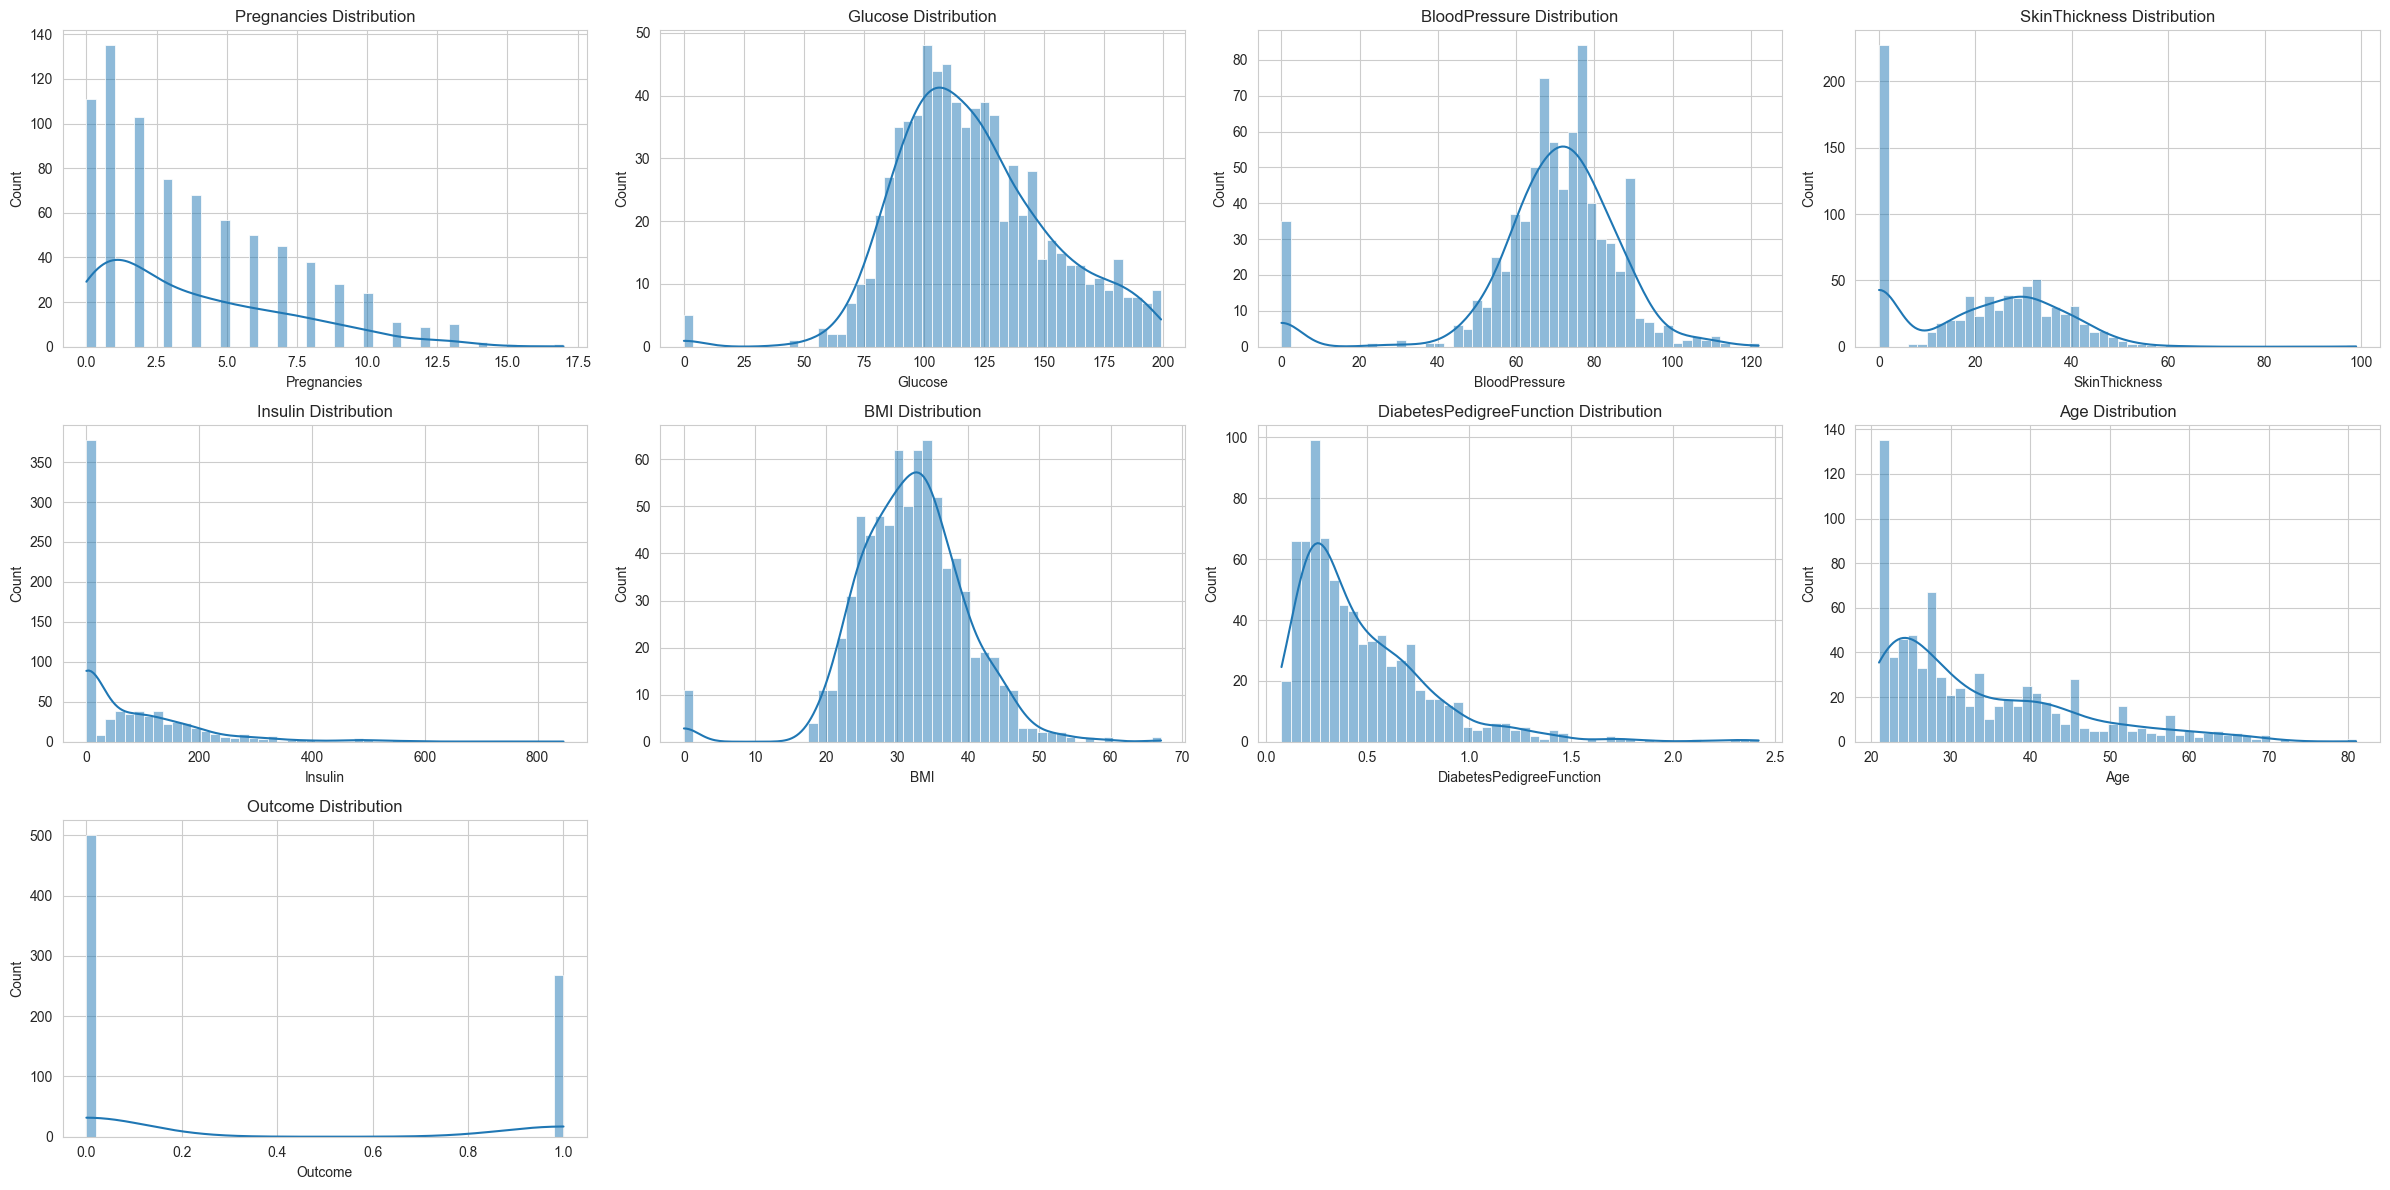

In [89]:
from src.visualization.plots import plot_multiple_features
plot_multiple_features(df=diabetes_data, bins=50, n_cols=4)

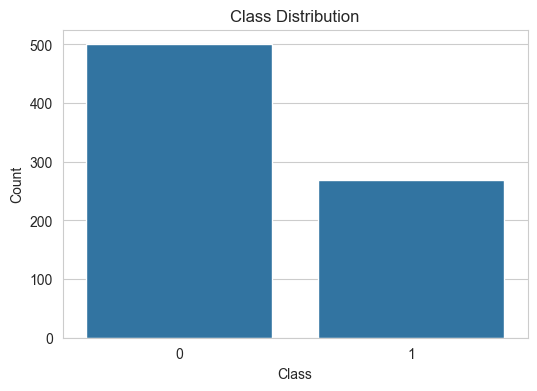

In [90]:
from src.visualization.plots import plot_class_distribution
plot_class_distribution(diabetes_data, 'Outcome')

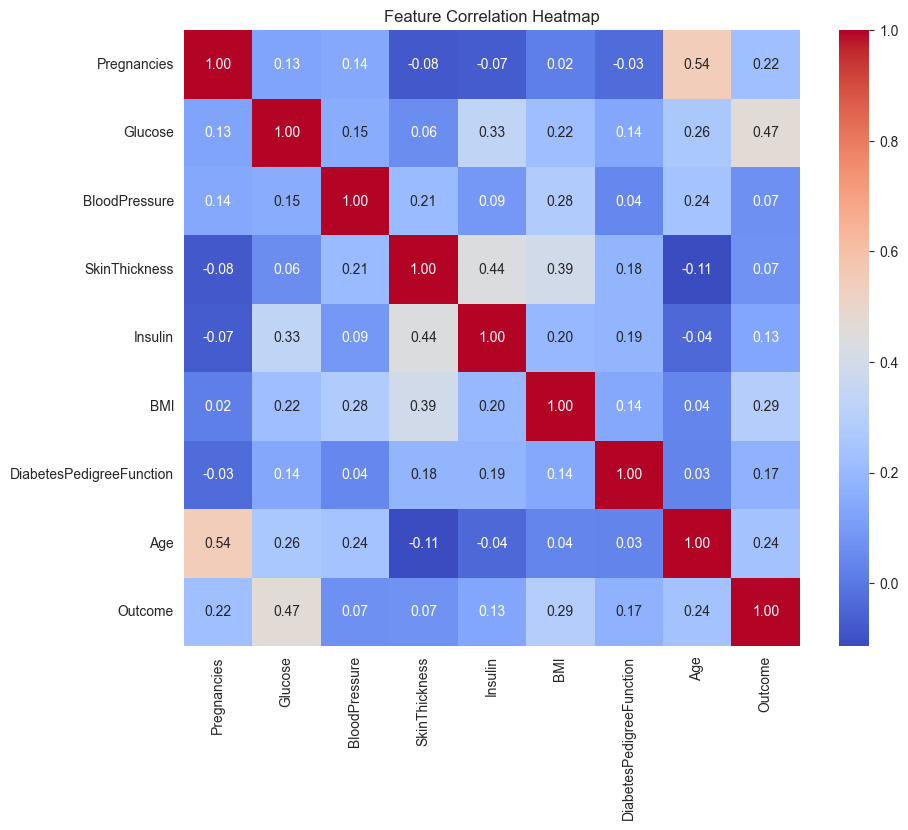

In [91]:
from src.visualization.plots import plot_correlation_heatmap

plot_correlation_heatmap(diabetes_data)

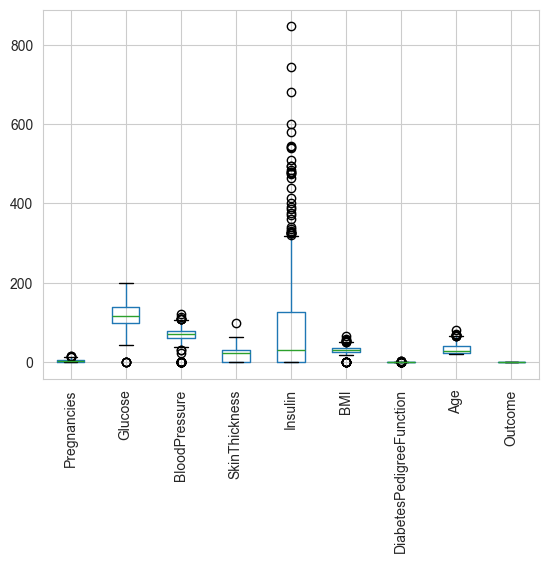

In [113]:
# box plot

diabetes_data.boxplot()
plt.xticks(rotation=90)
plt.show()

In [116]:
# now apply log to all features that are skewed
for col in diabetes_data.columns:
    diabetes_data[col] = np.log1p(diabetes_data[col])

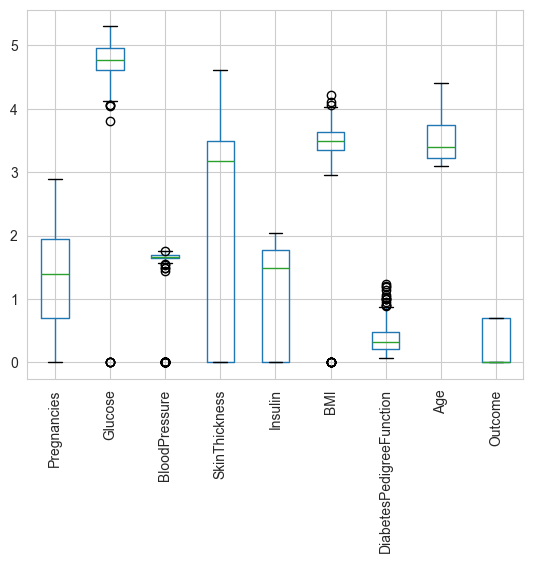

In [117]:
diabetes_data.boxplot()
plt.xticks(rotation=90)
plt.show()

In [118]:
from src.utils.main import corelation_data
corelation_data(diabetes_data, 'Outcome', method='pearson')

Outcome                     1.000000
Age                         0.274247
Glucose                     0.253576
DiabetesPedigreeFunction    0.179950
Pregnancies                 0.179739
BMI                         0.179640
SkinThickness              -0.007718
Insulin                    -0.016585
BloodPressure              -0.034269
Name: Outcome, dtype: float64

## Feature Engineering

In [119]:
data_enhance = diabetes_data.copy()

data_enhance['BMI_Age'] = data_enhance['BMI'] * data_enhance['Age']
data_enhance['Glucose_BMI'] = data_enhance['Glucose'] * data_enhance['BMI']
data_enhance['Glucose_Insulin'] = data_enhance['Glucose'] * data_enhance['Insulin']

# Create polynomial features
data_enhance['BMI_squared'] = data_enhance['BMI'] ** 2
data_enhance['Age_squared'] = data_enhance['Age'] ** 2
data_enhance['Glucose_squared'] = data_enhance['Glucose'] ** 2

# Create ratio features
data_enhance['Glucose_to_Insulin'] = data_enhance['Glucose'] / (data_enhance['Insulin'] + 1) 

In [123]:
from src.utils.main import corelation_data
corelation_data(data_enhance, 'Outcome', method='pearson')

Outcome                     1.000000
Glucose_squared             0.377623
BMI_Age                     0.294666
Glucose_BMI                 0.284855
Age                         0.274247
Age_squared                 0.265465
Glucose                     0.253576
BMI_squared                 0.253503
DiabetesPedigreeFunction    0.179950
Pregnancies                 0.179739
BMI                         0.179640
Glucose_to_Insulin          0.079226
Glucose_Insulin             0.010779
SkinThickness              -0.007718
Insulin                    -0.016585
BloodPressure              -0.034269
Name: Outcome, dtype: float64

## Split the data

In [124]:
X = data_enhance.drop("Outcome", axis=1)
y = data_enhance["Outcome"]

In [125]:
X.shape, y.shape

((768, 15), (768,))

In [126]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('baseline_classifier', RandomForestClassifier(random_state=42))
])

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_test)

print(f"Baseline Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Baseline Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Baseline Recall: {recall_score(y_test, y_pred_baseline):.4f}")


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [100]:
# Implement with GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
 
grid_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])


skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__class_weight":['balanced', None]
}

rf_grid = GridSearchCV(
    grid_pipeline,
    param_grid_rf,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__class_weight': ['balanced', None], 'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_leaf': [1, 2, ...], 'classifier__min_samples_split': [2, 5, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls th

In [103]:
print(f"\nBest RF parameters: {rf_grid.best_params_}")
print(f"Best RF CV score: {rf_grid.best_score_:.4f}")

y_pred_rf = rf_grid.predict(X_test)
print(f"\nRF Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"RF Test Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"RF Test Recall: {recall_score(y_test, y_pred_rf):.4f}")



Best RF parameters: {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best RF CV score: 0.7655

RF Test Accuracy: 0.7662
RF Test Precision: 0.6957
RF Test Recall: 0.5926


In [106]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

gb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 4, 5],
    'classifier__subsample': [0.8, 1.0]
}

print("Performing GridSearchCV for Gradient Boosting...")

gb_grid = GridSearchCV(
    gb_pipeline,
    param_grid_gb,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)

print(f"\nBest GB parameters: {gb_grid.best_params_}")
print(f"Best GB CV score: {gb_grid.best_score_:.4f}")

y_pred_gb = gb_grid.predict(X_test)
print(f"\nGB Test Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"GB Test Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"GB Test Recall: {recall_score(y_test, y_pred_gb):.4f}")

Performing GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best GB parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best GB CV score: 0.7524

GB Test Accuracy: 0.7208
GB Test Precision: 0.5821
GB Test Recall: 0.7222


In [105]:
# apply logistic regression
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

logreg_pipeline.fit(X_train, y_train)

y_pred_logreg = logreg_pipeline.predict(X_test)

print(f"\nLogistic Regression Test Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"Logistic Regression Test Precision: {precision_score(y_test, y_pred_logreg):.4f}")
print(f"Logistic Regression Test Recall: {recall_score(y_test, y_pred_logreg):.4f}")


Logistic Regression Test Accuracy: 0.7143
Logistic Regression Test Precision: 0.6136
Logistic Regression Test Recall: 0.5000


In [107]:
# apply the svm
from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42))
])

svm_pipeline.fit(X_train, y_train)

y_pred_svm = svm_pipeline.predict(X_test)

print(f"\nSVM Test Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"SVM Test Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"SVM Test Recall: {recall_score(y_test, y_pred_svm):.4f}")


SVM Test Accuracy: 0.7662
SVM Test Precision: 0.6957
SVM Test Recall: 0.5926


In [108]:
# apply xgboost
from xgboost import XGBClassifier

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42))
])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)

print(f"\nXGBoost Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost Test Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost Test Recall: {recall_score(y_test, y_pred_xgb):.4f}")


XGBoost Test Accuracy: 0.7403
XGBoost Test Precision: 0.6296
XGBoost Test Recall: 0.6296


In [111]:
# apply Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=42))
])

dt_pipeline.fit(X_train, y_train)

y_pred_dt = dt_pipeline.predict(X_test)

print(f"\nDecision Tree Test Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Decision Tree Test Precision: {precision_score(y_test, y_pred_dt):.4f}")
print(f"Decision Tree Test Recall: {recall_score(y_test, y_pred_dt):.4f}")


Decision Tree Test Accuracy: 0.7338
Decision Tree Test Precision: 0.6327
Decision Tree Test Recall: 0.5741
